# Pipeline Analyze
- Analyze results from predictions

In [107]:
# Configuraciones de Jupyter que sirven para que cambios en los scripts se actualicen automáticamente
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [108]:
import download

In [109]:
import models_multivariate as mv
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

In [110]:
# Parámetros del análisis
params= {
    'results_var_mx_no_trib': '../results/results_var_mx_no_trib.csv',
    'results_var_mx_trib': '../results/results_var_mx_w_trib.csv',
    'results_var_mx_trib_tot': '../results/results_var_mx_w_trib_tot_new.csv',
    'results_var': '../results/results_var.csv',
    'results_var_new': '../results/results_var_new.csv',
    'results_ml': '../results/results_ml.csv',
    'results_ml_new' : '../results/results_ML_new.csv',
    'results_ml_1000': '../results/results_ML_new_1000.csv',
    'results_arima': '../results/results_arima.csv',
    'results_arima_new': '../results/results_arima_new.csv',
    'results_arima_ing_tot': '../results/results_arima_new_ing_total.csv',
    'accuracy_meassure': 'rmse_first6'
}

In [111]:
# Importamos CSV's
results_var_mx_no_trib = pd.read_csv(params['results_var_mx_no_trib'])
results_var_mx_trib = pd.read_csv(params['results_var_mx_trib'])
results_var_mx_trib_tot = pd.read_csv(params['results_var_mx_trib_tot'])
results_var = pd.read_csv(params['results_var'])
results_var_new = pd.read_csv(params['results_var_new'])

results_ml = pd.read_csv(params['results_ml'])
results_ml['exog_vars'] = 'all'
results_ml_new = pd.read_csv(params['results_ml_new'])
results_ml_new['exog_vars'] = 'all_igae_sa'
results_ml_1000 = pd.read_csv(params['results_ml_1000'])
results_ml_1000['exog_vars'] = 'all_igae_sa'

results_arima = pd.read_csv(params['results_arima'])
results_arima_new = pd.read_csv(params['results_arima_new'])
results_arima_ing_tot = pd.read_csv(params['results_arima_ing_tot'])


results = pd.concat([results_var, results_var_new,
                     results_arima, results_arima_new, results_arima_ing_tot,
                     results_var_mx_no_trib, results_var_mx_trib, results_var_mx_trib_tot,
                     results_ml, results_ml_new, results_ml_1000], axis=0, sort=False)
results.drop('Unnamed: 0', axis=1, inplace=True)

# Organizamos el órden de las variables
var_order = [
 'model', 'params', 'endog_vars', 'exog_vars', 'variable', 'split_date','pred_period', 'forecast_biass_first6',
 'forecast_biass_first18', 'forecast_biass_last12', 'mape_first6', 'mape_first18', 'mape_last12', 'mae_first6',
 'mae_first18', 'mae_last12', 'rmse_first6', 'rmse_first18', 'rmse_last12']

results = results[var_order]
results = results.loc[results['split_date'] != '2019-07-01']

In [112]:
display(results.shape)
display(results.groupby('model').size())

(21468, 19)

model
ARIMA     1651
DT        9720
GB        2637
RF        3844
SARIMA    2608
VAR       1008
dtype: int64

In [113]:
# Nos quedamos solo con los modelos que se pudieron estimar para los 4 cortes
number_of_models = results.groupby(['model', 'params', 'endog_vars', 'exog_vars', 'variable']).size().reset_index()
number_of_models = number_of_models.loc[number_of_models[0]==number_of_models[0].max()]
results_complete = number_of_models.merge(results, left_on=['model', 'params', 'endog_vars', 'exog_vars', 'variable'],
                                           right_on = ['model', 'params', 'endog_vars', 'exog_vars', 'variable'])
results_complete.drop(0, axis=1, inplace=True)

In [114]:
display(results_complete.shape)
display(results_complete.groupby('model').size())

(21356, 19)

model
ARIMA     1580
DT        9720
GB        2596
RF        3844
SARIMA    2608
VAR       1008
dtype: int64

Perdimos  especificaciones porque no pudieron ser estimadas para todos los cortes. De ellas,  fueron ARIMA y  Gradient Boostin. 

In [115]:
# results_complete.loc[results_complete['model'] == 'RF'].groupby('params').mean().sort_values('mape_first6')

In [116]:
# results_complete.loc[(results_complete['exog_vars'] == 'all_igae_sa') &
#                      (results_complete['variable'] == 'importaciones_neto_(mdp)_r')].groupby(
#     'params').mean().sort_values('mape_first6')

In [117]:
# # Nos quedamos con los mejores modelos
# best_models = []
# for v, group_1 in results_complete.groupby('variable'):
#     for g, group_2 in group_1.groupby('model'):
#         for exog_var, group_3 in group_2.groupby('exog_vars'):
#             for endog_var, group_4 in group_3.groupby('endog_vars'):        
#                 df=group_4.groupby(['params']).mean()
#                 best = df.sort_values(params['accuracy_meassure']).reset_index().iloc[0]
#                 best_models.append({'variable':v, 'model': g, 'params': best['params'],
#                                     'exog_vars': exog_var, 'endog_vars': endog_var,
#                                     'mape_first6': best['mape_first6'], 'mape_first18': best['mape_first18'] ,
#                                     'mape_last12': best['mape_last12']})

                # Nos quedamos con los mejores modelos
best_models = []
for v, group_1 in results_complete.groupby('variable'):
    for g, group_2 in group_1.groupby('model'):
        df = group_2.groupby(['exog_vars', 'endog_vars', 'params']).mean()        
        best = df.sort_values(params['accuracy_meassure']).reset_index().iloc[0]
        best_models.append({'variable':v, 'model': g, 'params': best['params'],
                            'exog_vars': best['exog_vars'], 'endog_vars': best['endog_vars'],
                            'mape_first6': best['mape_first6'], 'mape_first18': best['mape_first18'] ,
                            'mape_last12': best['mape_last12'], 'rmse_first6': best['rmse_first6'],
                            'rmse_first18': best['rmse_first18'], 'rmse_last12': best['rmse_last12']})

In [118]:
best_models = pd.DataFrame(best_models)[['variable', 'model', 'params', 'endog_vars',
                                        'exog_vars', 'mape_first6',
                                        'mape_first18', 'mape_last12', 'rmse_first6',
                                        'rmse_last12', 'rmse_first18']]

In [119]:
variables_de_interes = ['ing_trib_neto_(mdp)_r', 'ing_trib_sin_gasol_neto_(mdp)_r',
                        'isr_neto_(mdp)_r', 'iva_neto_(mdp)_r', 'importaciones_neto_(mdp)_r',
                       'ieps_sin_gas_neto_(mdp)_r']

In [120]:
best_models.loc[best_models['variable'].isin(variables_de_interes)].sort_values(
    ['variable', params['accuracy_meassure']]).to_excel('../results/tabla_resultados_rmse_first18.xlsx', index=False)

In [121]:
best_models.loc[best_models['variable'] == 'igae', 'endog_vars'].values

array(["['igae', 'tc_mensual', 'tasa_cetes_91_mensual', 'inpc', 'importaciones_r', 'indic_mens_consumo']"],
      dtype=object)

In [122]:
# best_models[best_models['variable'].isin(variables_de_interes)].sort_values(['variable', params['accuracy_meassure']])\
#     .to_csv('../results/mejores_{}.csv'.format(params['accuracy_meassure']))

In [129]:
best_models[best_models['variable']=='importaciones_neto_(mdp)_r'].sort_values(['variable', params['accuracy_meassure']])\
    .values

array([['importaciones_neto_(mdp)_r', 'GB',
        "{'learning_rate': 0.5, 'max_depth': 1, 'n_estimators': 50, 'random_state': 1234, 'subsample': 1.0}",
        "['importaciones_neto_(mdp)_r']", 'all', 0.050402659135613426,
        0.1407831284511348, 0.19999488449018762, 312.6699523839553,
        1146.866460865826, 919.7765966051027],
       ['importaciones_neto_(mdp)_r', 'RF',
        "{'criterion': 'mse', 'max_depth': 50, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 1000, 'n_jobs': -1, 'random_state': 1234}",
        "['importaciones_neto_(mdp)_r']", 'all', 0.06436194674808274,
        0.11110630529992709, 0.13961027100886803, 381.86170420941744,
        832.5823444466, 705.0533754144651],
       ['importaciones_neto_(mdp)_r', 'DT',
        "{'criterion': 'mse', 'max_depth': 10, 'max_features': None, 'min_samples_split': 2, 'random_state': 1234}",
        "['isr_neto_(mdp)_r', 'iva_neto_(mdp)_r', 'importaciones_neto_(mdp)_r']",
        'all', 0.07263486222032363

# HASTA AQUI

# HASTA AQUI

# HASTA AQUI

# HASTA AQUI

# HASTA AQUI

# HASTA AQUI

In [99]:
# best_models.index=best_models['endog_vars']
# best_models.sort_values(['variable', 'mape_first6'])
# best_models = best_models.reset_index()

In [100]:
best_models.drop(['mape_first6', 'mape_first18', 'mape_last12',
                  'rmse_first6', 'rmse_first18', 'rmse_last12'], axis=1, inplace=True)
best_models = pd.merge(best_models, results_complete, left_on=['variable', 'model', 'params', 'exog_vars', 'endog_vars'], 
                       right_on=['variable', 'model', 'params', 'exog_vars', 'endog_vars'])

np.arange(0, len(best_mape))

In [101]:
best_models.loc[best_models['variable'] == 'isr_neto_(mdp)_r'].sort_values(params['accuracy_meassure'])

variable   model  \
127  isr_neto_(mdp)_r  SARIMA   
126  isr_neto_(mdp)_r  SARIMA   
111  isr_neto_(mdp)_r   ARIMA   
128  isr_neto_(mdp)_r     VAR   
116  isr_neto_(mdp)_r      GB   
131  isr_neto_(mdp)_r     VAR   
109  isr_neto_(mdp)_r   ARIMA   
114  isr_neto_(mdp)_r      DT   
130  isr_neto_(mdp)_r     VAR   
124  isr_neto_(mdp)_r  SARIMA   
112  isr_neto_(mdp)_r      DT   
108  isr_neto_(mdp)_r   ARIMA   
123  isr_neto_(mdp)_r      RF   
119  isr_neto_(mdp)_r      GB   
110  isr_neto_(mdp)_r   ARIMA   
125  isr_neto_(mdp)_r  SARIMA   
120  isr_neto_(mdp)_r      RF   
113  isr_neto_(mdp)_r      DT   
129  isr_neto_(mdp)_r     VAR   
118  isr_neto_(mdp)_r      GB   
122  isr_neto_(mdp)_r      RF   
121  isr_neto_(mdp)_r      RF   
117  isr_neto_(mdp)_r      GB   
115  isr_neto_(mdp)_r      DT   

                                                params  \
127  {'enforce_invertibility': False, 'enforce_stat...   
126  {'enforce_invertibility': False, 'enforce_stat...   
111                               {'order': (1, 0, 4)}   
128        {'ic': 'bic', 'maxlags': 12, 'trend': 'ct'}   
116  {'learning_rate': 0.1, 'max_depth': 5, 'n_esti...   
131        {'ic': 'bic', 'maxlags': 12, 'trend': 'ct'}   
109                               {'order': (1, 0, 4)}   
114  {'criterion': 'mae', 'max_depth': 5, 'max_feat...   
130        {'ic': 'bic', 'maxlags': 12, 'trend': 'ct'}   
124  {'enforce_invertibility': False, 'enforce_stat...   
112  {'criterion': 'mae', 'max_depth': 5, 'max_feat...   
108                               {'order': (1, 0, 4)}   
123  {'criterion': 'mse', 'max_depth': 50, 'max_fea...   
119  {'learning_rate': 0.1, 'max_depth': 5, 'n_esti...   
110                               {'order': (1, 0, 4)}   
125  {'enforce_invertibility': False, 'enforce_stat...   
120  {'criterion': 'mse', 'max_depth': 50, 'max_fea...   
113  {'criterion': 'mae', 'max_depth': 5, 'max_feat...   
129        {'ic': 'bic', 'maxlags': 12, 'trend': 'ct'}   
118  {'learning_rate': 0.1, 'max_depth': 5, 'n_esti...   
122  {'criterion': 'mse', 'max_depth': 50, 'max_fea...   
121  {'criterion': 'mse', 'max_depth': 50, 'max_fea...   
117  {'learning_rate': 0.1, 'max_depth': 5, 'n_esti...   
115  {'criterion': 'mae', 'max_depth': 5, 'max_feat...   

                                            endog_vars  \
127                               ['isr_neto_(mdp)_r']   
126                               ['isr_neto_(mdp)_r']   
111                               ['isr_neto_(mdp)_r']   
128  ['isr_neto_(mdp)_r', 'importaciones_neto_(mdp)...   
116  ['isr_neto_(mdp)_r', 'iva_neto_(mdp)_r', 'ing_...   
131  ['isr_neto_(mdp)_r', 'importaciones_neto_(mdp)...   
109                               ['isr_neto_(mdp)_r']   
114                               ['isr_neto_(mdp)_r']   
130  ['isr_neto_(mdp)_r', 'importaciones_neto_(mdp)...   
124                               ['isr_neto_(mdp)_r']   
112                               ['isr_neto_(mdp)_r']   
108                               ['isr_neto_(mdp)_r']   
123           ['isr_neto_(mdp)_r', 'iva_neto_(mdp)_r']   
119  ['isr_neto_(mdp)_r', 'iva_neto_(mdp)_r', 'ing_...   
110                               ['isr_neto_(mdp)_r']   
125                               ['isr_neto_(mdp)_r']   
120           ['isr_neto_(mdp)_r', 'iva_neto_(mdp)_r']   
113                               ['isr_neto_(mdp)_r']   
129  ['isr_neto_(mdp)_r', 'importaciones_neto_(mdp)...   
118  ['isr_neto_(mdp)_r', 'iva_neto_(mdp)_r', 'ing_...   
122           ['isr_neto_(mdp)_r', 'iva_neto_(mdp)_r']   
121           ['isr_neto_(mdp)_r', 'iva_neto_(mdp)_r']   
117  ['isr_neto_(mdp)_r', 'iva_neto_(mdp)_r', 'ing_...   
115                               ['isr_neto_(mdp)_r']   

                                             exog_vars  split_date  \
127  ['igae_sa', 'inpc', 'tasa_cetes_91_mensual', '...  2018-07-01   
126  ['igae_sa', 'inpc', 'tasa_cetes_91_mensual', '...  2017-07-01   
111  ['mes_1', 'mes_3', 'mes_4', 'mes_12', 'year_20...  2018-07-01   
128  

In [102]:
variables_de_interes = ['ing_trib_neto_(mdp)_r', 'ing_trib_sin_gasol_neto_(mdp)_r',
                        'isr_neto_(mdp)_r', 'iva_neto_(mdp)_r', 'importaciones_neto_(mdp)_r',
                       'ieps_sin_gas_neto_(mdp)_r']
varname_dict = {'ing_trib_neto_(mdp)_r': 'Ingresos tributarios',
                'ing_trib_sin_gasol_neto_(mdp)_r': 'Ingresos tributarios sin gas',
                'isr_neto_(mdp)_r': 'ISR',
                'iva_neto_(mdp)_r': 'IVA',
                'importaciones_neto_(mdp)_r': 'Impuesto a las importaciones',
                'ieps_sin_gas_neto_(mdp)_r': 'IEPS sin gasolina'}

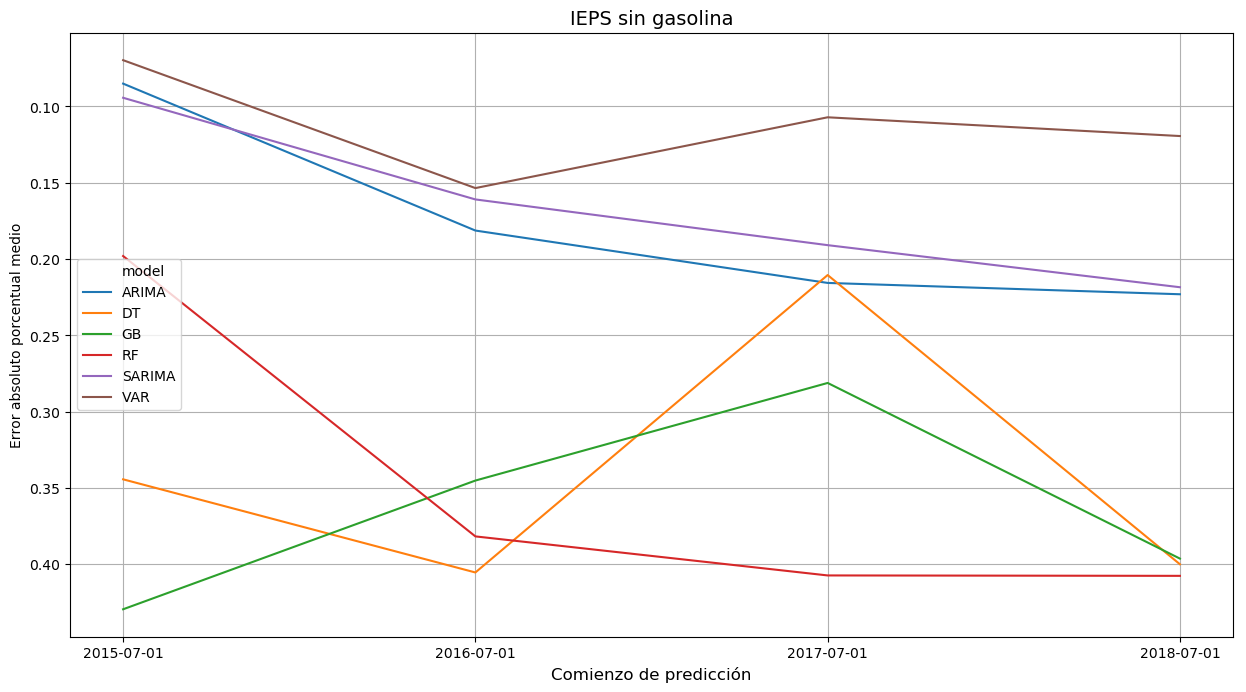

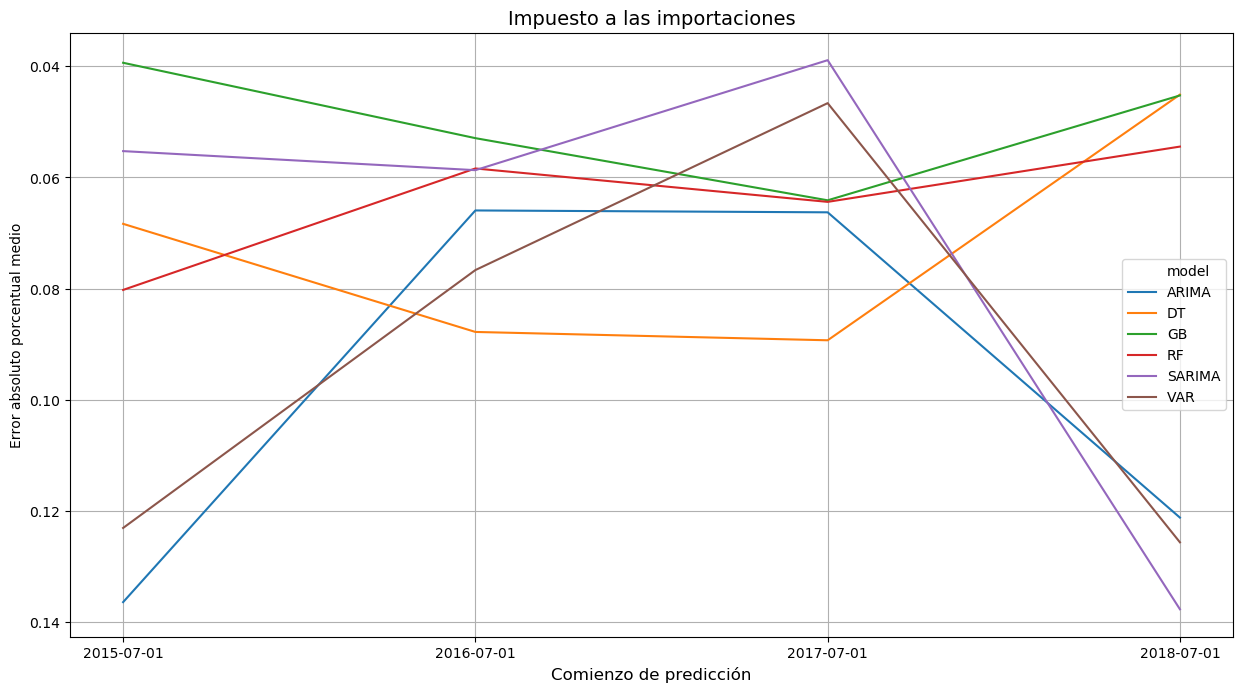

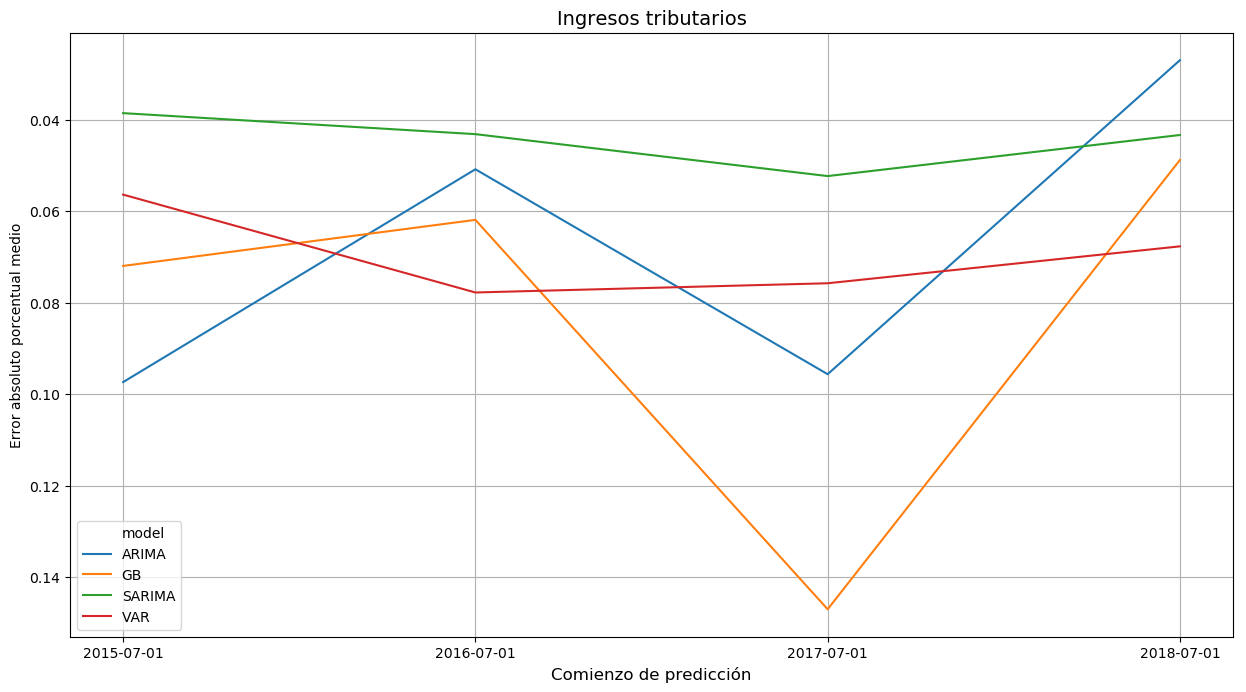

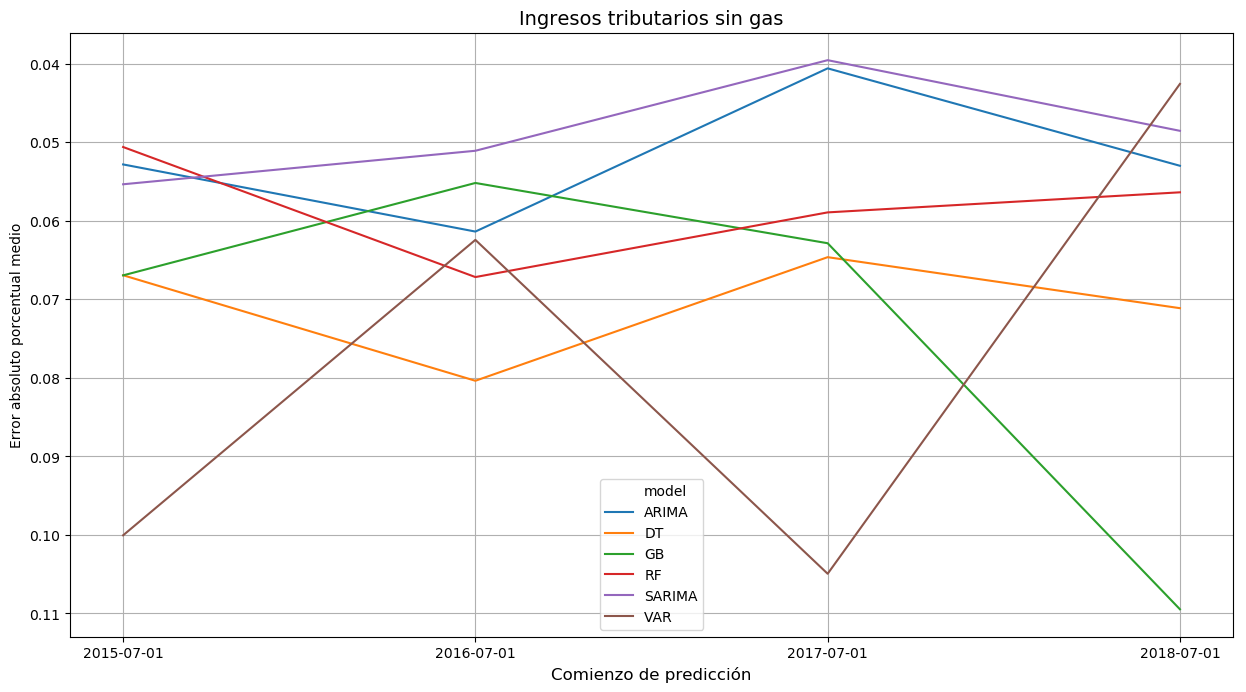

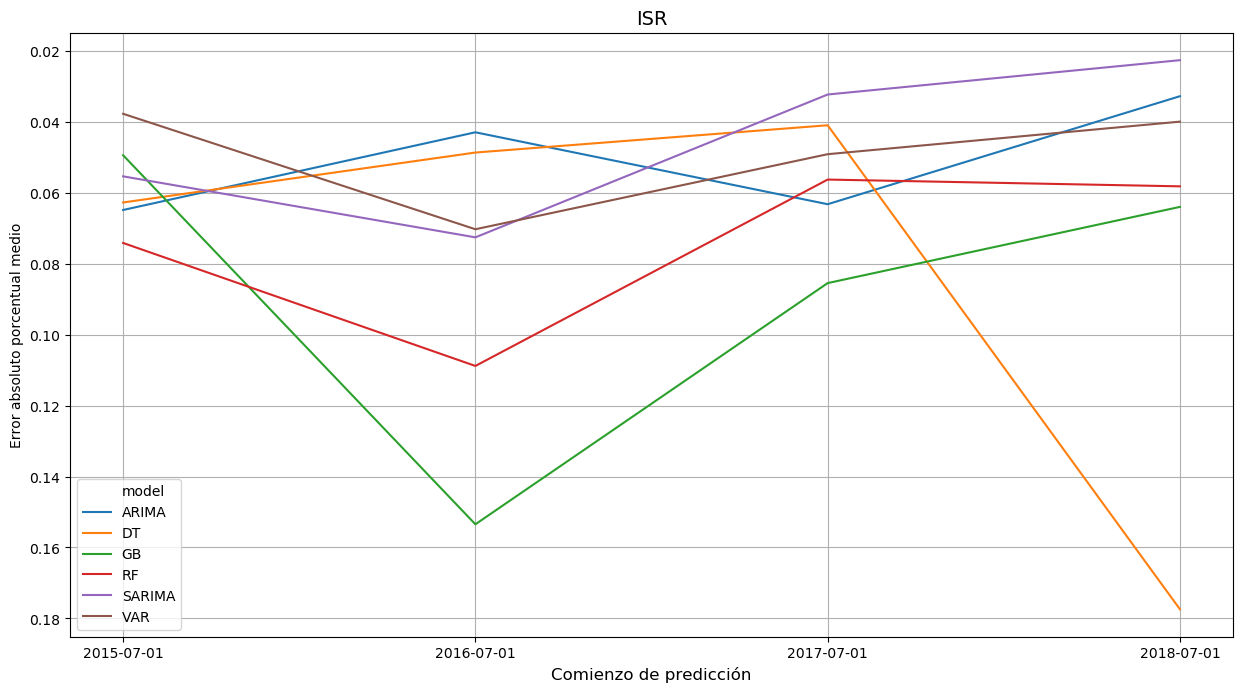

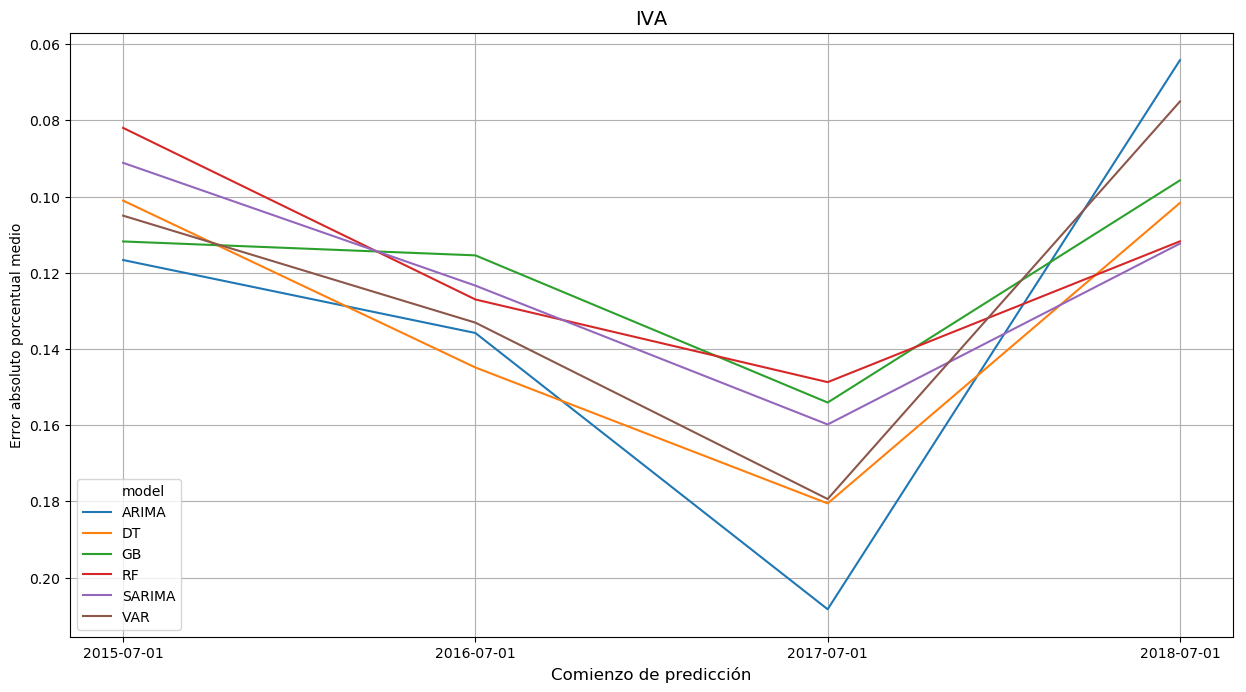

In [105]:
for var, df in best_models.loc[best_models['split_date'] < '2019-01-01'].groupby('variable'):
    if var not in variables_de_interes:
        continue
        
    summary_levels = pd.pivot_table(df,
                                    index=['model', 'exog_vars', 'split_date'],
                                    aggfunc='min',
                                    fill_value=0)
    summary_levels = summary_levels.reset_index()
    summary_levels['model_vars'] = summary_levels['model'] + summary_levels['exog_vars']
    fig, ax = plt.subplots(figsize=(15,8), dpi=100)
    sns.lineplot(x="split_date", y='mape_first6', hue='model',
                 data=summary_levels, ax=ax)
    ax.invert_yaxis()
    ax.set_xlabel("Comienzo de predicción", fontsize=12)
    ax.set_ylabel("Error absoluto porcentual medio")
    ax.set_title(varname_dict[var], fontsize=14)
    ax.grid()
#     plt.savefig('../reporte/figures/'+var+'_prec_cierre.png')
    plt.show()

In [19]:
best_models.to_excel('mejores_modelos_mensuales.xlsx', index=False)

In [20]:
best_models.groupby(['variable', 'model', 'params', 'exog_vars', 'endog_vars']).mean()[['mape_first6', 'mape_first18']]\
    .sort_values('mape_first6').sort_index(level=0)

mape_first6  \
variable                        model  params                                             exog_vars                                          endog_vars                                                        
ieps_sin_gas_neto_(mdp)_r       ARIMA  {'order': (4, 0, 3)}                               ['igae', 'inpc', 'tasa_cetes_91_mensual', 'tc_m... ['ieps_sin_gas_neto_(mdp)_r']                          0.149797   
                                DT     {'criterion': 'mae', 'max_depth': 20, 'max_feat... all                                                ['ieps_sin_gas_neto_(mdp)_r']                          0.339099   
                                GB     {'learning_rate': 0.5, 'max_depth': 1, 'n_estim... all                                                ['isr_neto_(mdp)_r', 'iva_neto_(mdp)_r', 'ing_t...     0.362959   
                                RF     {'criterion': 'mse', 'max_depth': 50, 'max_feat... all                                                ['ieps_sin_gas_neto_(mdp)_r']                          0.346159   
                                SARIMA {'enforce_invertibility': False, 'enforce_stati... ['igae', 'inpc', 'tasa_cetes_91_mensual', 'tc_m... ['ieps_sin_gas_neto_(mdp)_r']                          0.157890   
                                VAR    {'ic': 'aic', 'maxlags': 12, 'trend': 'ct'}        ['igae', 'inpc', 'tasa_cetes_91_mensual', 'tc_m... ['isr_neto_(mdp)_r', 'iva_neto_(mdp)_r', 'ieps_...     0.112415   
igae                            VAR    {'ic': 'aic', 'maxlags': 12, 'trend': 'ct'}        ['commodity_price_index', 'cons_price_index_us'... ['igae', 'tc_mensual', 'tasa_cetes_91_mensual',...     0.015709   
igae_sa                         VAR    {'ic': 'bic', 'maxlags': 12, 'trend': 'c'}         ['commodity_price_index', 'cons_price_index_us'... ['igae_sa', 'tc_mensual', 'tasa_cetes_91_mensua...     0.005039   
importaciones_neto_(mdp)_r      ARIMA  {'order': (4, 0, 3)}                               ['mes_1', 'mes_3', 'mes_4', 'mes_12', 'year_200... ['importaciones_neto_(mdp)_r']                         0.096684   
                                DT     {'criterion': 'mae', 'max_depth': 1, 'max_featu... all                                                ['importaciones_neto_(mdp)_r']                         0.071747   
                                GB     {'learning_rate': 0.5, 'max_depth': 1, 'n_estim... all                                                ['importaciones_neto_(mdp)_r']                         0.050403   
                                RF     {'criterion': 'mse', 'max_depth': 50, 'max_feat... all                                                ['importaciones_neto_(mdp)_r']                         0.064362   
                                SARIMA {'enforce_invertibility': False, 'enforce_stati... ['mes_1', 'mes_3', 'mes_4', 'mes_12', 'year_200... ['importaciones_neto_(mdp)_r']                         0.072638   
                                VAR    {'ic': 'fpe', 'maxlags': 12, 'trend': 'c'}         ['igae', 'inpc', 'tasa_cetes_91_mensual', 'tc_m... ['isr_neto_(mdp)_r', 'iva_neto_(mdp)_r', 'impor...     0.090538   
importaciones_r                 VAR    {'ic': 'bic', 'maxlags': 12, 'trend': 'c'}         ['commodity_price_index', 'cons_price_index_us'... ['igae', 'tc_mensual', 'tasa_cetes_91_mensual',...     0.048332   
indic_mens_consumo              VAR    {'ic': 'aic', 'maxlags': 12, 'trend': 'c'}         ['commodity_price_index', 'cons_price_index_us'... ['igae', 'tc_mensual', 'tasa_cetes_91_mensual',...     0.016146   
ing_trib_neto_(mdp)_r           ARIMA  {'order': (2, 0, 4)}                               ['igae_sa', 'inpc', 'tasa_cetes_91_mensual', 't... ['ing_trib_neto_(mdp)_r']                              0.065324   
                                GB     {'learning_rate': 0.1, 'max_depth': 5, 'n_estim... all_igae_sa                                        ['ing_trib_neto_(mdp)_r']                              0.082382   
                                S

# Precisiones de cierre

In [332]:
precision_cierre_arima_tot = pd.read_csv('../results/precision_cierre_arima_ing_trib_ing_total.csv')
precision_cierre_arima_ing_trib = pd.read_csv('../results/precision_cierre_arima_ing_trib.csv')
estimacion_cierre_mod_tot = pd.read_csv('../results/estimacion_cierre_ml_modelototal.csv')
estimacion_cierre_ml_modelostotales = pd.read_csv('../results/estimacion_cierre_ml_modelostotales.csv')
precision_cierre_mx_var_no_trib = pd.read_csv('../results/precision_cierre_mx_var_no_trib.csv')
precision_cierre_mx_var_w_trib = pd.read_csv('../results/precision_cierre_mx_var_w_trib.csv')
precision_cierre_var_ing_trib = pd.read_csv('../results/precision_cierre_var_ing_trib.csv')
precision_cierre_var_mx_ing_trib= pd.read_csv('../results/precision_cierre_mx_var_w_trib_tot.csv')

In [333]:
y_precisions = pd.concat([precision_cierre_arima_tot, precision_cierre_arima_ing_trib, estimacion_cierre_mod_tot,
           estimacion_cierre_ml_modelostotales, precision_cierre_mx_var_no_trib, precision_cierre_mx_var_w_trib,
           precision_cierre_var_ing_trib, precision_cierre_var_mx_ing_trib], sort=False)

In [334]:
y_precisions.drop('Unnamed: 0', axis=1, inplace=True)
y_precisions = y_precisions.reset_index()
y_precisions.drop('index', axis=1, inplace=True)

In [335]:
y_precisions = y_precisions.melt(id_vars=['model', 'params', 'endog_vars', 'exog_vars', 'split_date'],
                  var_name='variable',
                  value_name='precision_cierre')

In [366]:
def split_yearly_precs(x, anio):
    if x != x:
        return (np.nan, np.nan)
    precisions = re.findall('[-\d]+\.\d+', x)
    return (float(precisions[anio]))

<>:4: DeprecationWarning: invalid escape sequence \d
<>:4: DeprecationWarning: invalid escape sequence \d
<>:4: DeprecationWarning: invalid escape sequence \d
<ipython-input-366-5160314b9020>:4: DeprecationWarning: invalid escape sequence \d
  precisions = re.findall('[-\d]+\.\d+', x)


In [367]:
y_precisions['cierre_0'] = y_precisions['precision_cierre'].map(lambda x: split_yearly_precs(x, 0))
y_precisions['cierre_1'] = y_precisions['precision_cierre'].map(lambda x: split_yearly_precs(x, 1))
y_precisions['abs_cierre_0'] = abs(y_precisions['cierre_0'])
y_precisions['abs_cierre_1'] = abs(y_precisions['cierre_1'])



In [377]:
y_precisions = y_precisions.loc[y_precisions['precision_cierre'].notna()]
y_precisions = y_precisions.loc[y_precisions['split_date'] != '2019-01-01']

In [388]:
cierre_best = y_precisions.loc[y_precisions['variable'] == 'importaciones_neto_(mdp)_r'].groupby(
    ['model', 'params', 'endog_vars', 'exog_vars']).mean().reset_index().sort_values('abs_cierre_0')
cierre_best.index = cierre_best['params']
cierre_best

model  \
params                                                       
{'learning_rate': 0.1, 'max_depth': 5, 'n_estim...      GB   
{'learning_rate': 0.1, 'max_depth': 5, 'n_estim...      GB   
{'order': (4, 0, 4)}                                 ARIMA   
{'learning_rate': 0.1, 'max_depth': 10, 'n_esti...      GB   
{'learning_rate': 0.5, 'max_depth': 5, 'n_estim...      GB   
{'learning_rate': 0.1, 'max_depth': 5, 'n_estim...      GB   
{'order': (3, 0, 3)}                                 ARIMA   
{'learning_rate': 0.5, 'max_depth': 5, 'n_estim...      GB   
{'enforce_invertibility': False, 'enforce_stati...  SARIMA   
{'enforce_invertibility': False, 'enforce_stati...  SARIMA   
{'order': (4, 0, 3)}                                 ARIMA   
{'enforce_invertibility': False, 'enforce_stati...  SARIMA   
{'enforce_invertibility': False, 'enforce_stati...  SARIMA   
{'order': (2, 0, 2)}                                 ARIMA   
{'enforce_invertibility': False, 'enforce_stati...  SARIMA   
{'order': (3, 0, 2)}                                 ARIMA   
{'learning_rate': 0.1, 'max_depth': 5, 'n_estim...      GB   
{'learning_rate': 0.1, 'max_depth': 5, 'n_estim...      GB   
{'learning_rate': 0.1, 'max_depth': 5, 'n_estim...      GB   
{'order': (2, 0, 3)}                                 ARIMA   
{'ic': 'bic', 'maxlags': 12, 'trend': 'ct'}            VAR   
{'enforce_invertibility': False, 'enforce_stati...  SARIMA   
{'enforce_invertibility': False, 'enforce_stati...  SARIMA   
{'enforce_invertibility': False, 'enforce_stati...  SARIMA   
{'enforce_invertibility': False, 'enforce_stati...  SARIMA   
{'order': (4, 0, 3)}                                 ARIMA   
{'ic': 'bic', 'maxlags': 12, 'trend': 'c'}             VAR   
{'ic': 'aic', 'maxlags': 12, 'trend': 'c'}             VAR   
{'ic': 'fpe', 'maxlags': 12, 'trend': 'c'}             VAR   
{'order': (4, 0, 2)}                                 ARIMA   
{'enforce_invertibility': False, 'enforce_stati...  SARIMA   
{'enforce_invertibility': False, 'enforce_stati...  SARIMA   
{'enforce_invertibility': False, 'enforce_stati...  SARIMA   
{'order': (3, 0, 2)}                                 ARIMA   
{'enforce_invertibility': False, 'enforce_stati...  SARIMA   
{'order': (2, 0, 4)}                                 ARIMA   
{'learning_rate': 0.1, 'max_depth': 10, 'n_esti...      GB   
{'order': (4, 0, 4)}                                 ARIMA   
{'enforce_invertibility': False, 'enforce_stati...  SARIMA   
{'enforce_invertibility': False, 'enforce_stati...  SARIMA   
{'order': (2, 0, 4)}                                 ARIMA   
{'order': (2, 0, 2)}                                 ARIMA   
{'enforce_invertibility': False, 'enforce_stati...  SARIMA   
{'order': (4, 0, 2)}                                 ARIMA   
{'enforce_invertibility': False, 'enforce_stati...  SARIMA   
{'enforce_invertibility': False, 'enforce_stati...  SARIMA   
{'enforce_invertibility': False, 'enforce_stati...  SARIMA   
{'order': (3, 0, 3)}                                 ARIMA   
{'enforce_invertibility': False, 'enforce_stati...  SARIMA   
{'enforce_invertibility': False, 'enforce_stati...  SARIMA   
{'order': (2, 0, 3)}                                 ARIMA   
{'order': (3, 0, 4)}                                 ARIMA   
{'enforce_invertibility': False, 'enforce_stati...  SARIMA   
{'learning_rate': 0.1, 'max_depth': 10, 'n_esti...      GB   
{'enforce_invertibility': False, 'enforce_stati...  SARIMA   
{'learning_rate': 0.1, 'max_depth': 10, 'n_esti...      GB   
{'order': (3, 0, 4)}                                 ARIMA   
{'ic': 'aic', 'maxlags': 12, 'trend': 'ct'}            VAR   
{'ic': 'fpe', 'maxlags': 12, 'trend': 'ct'}            VAR   
{'enforce_invertibility': False, 'enforce_stati...  SARIMA   
{'enforce_invertibility': False, 'enforce_stati...  SARIMA   
{'enforce_invertibility': False, 'enforce_stati...  SARIMA   
{'enforce_invertibility': False, 'enforce_stati...  SARIMA   
{'enforce_invertibility

In [380]:
variable = 'ing_trib_neto_(mdp)_r'
model = 'SARIMA'
param = "{'enforce_invertibility': False, 'enforce_stationarity': False, 'order': (2, 0, 2), 'seasonal_order': (1, 0, 1, 12)}"

In [381]:
y_precisions.loc[(y_precisions['variable'] == variable) &
                (y_precisions['model'] == model) &
                (y_precisions['params'] == param)].sort_values('split_date')
                    

model                                             params  \
39  SARIMA  {'enforce_invertibility': False, 'enforce_stat...   
55  SARIMA  {'enforce_invertibility': False, 'enforce_stat...   
71  SARIMA  {'enforce_invertibility': False, 'enforce_stat...   
87  SARIMA  {'enforce_invertibility': False, 'enforce_stat...   

                   endog_vars  \
39  ['ing_trib_neto_(mdp)_r']   
55  ['ing_trib_neto_(mdp)_r']   
71  ['ing_trib_neto_(mdp)_r']   
87  ['ing_trib_neto_(mdp)_r']   

                                            exog_vars  split_date  \
39  ['igae_sa', 'inpc', 'tasa_cetes_91_mensual', '...  2015-07-01   
55  ['igae_sa', 'inpc', 'tasa_cetes_91_mensual', '...  2016-07-01   
71  ['igae_sa', 'inpc', 'tasa_cetes_91_mensual', '...  2017-07-01   
87  ['igae_sa', 'inpc', 'tasa_cetes_91_mensual', '...  2018-07-01   

                 variable                                   precision_cierre  \
39  ing_trib_neto_(mdp)_r  {Timestamp('2015-01-01 00:00:00', freq='AS-JAN...   
55  ing_trib_neto_(mdp)_r  {Timestamp('2016-01-01 00:00:00', freq='AS-JAN...   
71  ing_trib_neto_(mdp)_r  {Timestamp('2017-01-01 00:00:00', freq='AS-JAN...   
87  ing_trib_neto_(mdp)_r  {Timestamp('2018-01-01 00:00:00', freq='AS-JAN...   

        cierre_0      cierre_1  abs_cierre_0  abs_cierre_1  
39 -45995.500691  1.795719e+05  45995.500691  1.795719e+05  
55 -30324.300842 -5.068681e+05  30324.300842  5.068681e+05  
71   8619.693699 -1.056369e+05   8619.693699  1.056369e+05  
87 -48461.334241 -1.876467e+06  48461.334241  1.876467e+06

# Veamos el error de las estimaciones de la LIF

In [21]:
calendario_lif = download.load_calendario_lif()

In [22]:
ingresos_netos = download.load_ingresos_fiscales_netos()

In [23]:
calendario_lif.columns

Index(['ingresos_del_sector_public_presupuestado',
       'ingresos_gobierno_federal_presupuestado',
       'ingresos_tributarios_presupuestado', 'isr_presupuestado',
       'iva_presupuestado', 'ieps_presupuestado',
       'importaciones_presupuestado', 'otros impuestos_presupuestado',
       'derechos_presupuestado', 'aprovechamientos_presupuestado',
       'transferencias_fmp_presupuestado',
       'otros no tributarios_presupuestado',
       'ingresos_no_tributatios_presupuestado', 'inpc',
       'ingresos_del_sector_public_presupuestado_r',
       'ingresos_gobierno_federal_presupuestado_r',
       'ingresos_tributarios_presupuestado_r', 'isr_presupuestado_r',
       'iva_presupuestado_r', 'ieps_presupuestado_r',
       'importaciones_presupuestado_r', 'otros impuestos_presupuestado_r',
       'derechos_presupuestado_r', 'aprovechamientos_presupuestado_r',
       'transferencias_fmp_presupuestado_r',
       'otros no tributarios_presupuestado_r',
       'ingresos_no_tributatios_pr

In [24]:
ingresos_netos.columns

Index(['ingresos_sector_publico_neto_(mdp)', 'ieps_neto_(mdp)',
       'ieps_sin_gas_neto_(mdp)', 'ing_gob_fed_neto_(mdp)',
       'ing_trib_neto_(mdp)', 'isr_neto_(mdp)', 'iva_neto_(mdp)',
       'importaciones_neto_(mdp)', 'ing_no_trib_neto_(mdp)',
       'ieps_hidrocarburos_neto_(mdp)', 'ieps_otros_petroliferos_neto_(mdp)',
       'ieps_gasolina_neto_(mdp)', 'ieps_tabaco_neto_(mdp)',
       'ieps_ba_neto_(mdp)', 'ieps_cerveza_neto_(mdp)',
       'ieps_telecom_neto_(mdp)', 'ieps_otras_retenciones_neto_(mdp)',
       'exportaciones_neto_(mdp)', 'isan_neto_(mdp)',
       'accesorios_contribuciones_neto_(mdp)',
       'otros_ingresos_tributarios_neto_(mdp)', 'ietu_neto_(mdp)',
       'ide_neto_(mdp)', 'ieps_jys_neto_(mdp)', 'ieps_be_neto_(mdp)',
       'ieps_bsaborizadas_neto_(mdp)', 'ieps_aadc_neto_(mdp)',
       'ieps_plaguicidas_neto_(mdp)', 'ieps_combustibles_fosiles_neto_(mdp)',
       'impuesto_extraccion_hidrocarburos_neto_(mdp)',
       'ing_trib_sin_gasol_neto_(mdp)', 'inpc',
 

In [25]:
calendario_lif.columns

Index(['ingresos_del_sector_public_presupuestado',
       'ingresos_gobierno_federal_presupuestado',
       'ingresos_tributarios_presupuestado', 'isr_presupuestado',
       'iva_presupuestado', 'ieps_presupuestado',
       'importaciones_presupuestado', 'otros impuestos_presupuestado',
       'derechos_presupuestado', 'aprovechamientos_presupuestado',
       'transferencias_fmp_presupuestado',
       'otros no tributarios_presupuestado',
       'ingresos_no_tributatios_presupuestado', 'inpc',
       'ingresos_del_sector_public_presupuestado_r',
       'ingresos_gobierno_federal_presupuestado_r',
       'ingresos_tributarios_presupuestado_r', 'isr_presupuestado_r',
       'iva_presupuestado_r', 'ieps_presupuestado_r',
       'importaciones_presupuestado_r', 'otros impuestos_presupuestado_r',
       'derechos_presupuestado_r', 'aprovechamientos_presupuestado_r',
       'transferencias_fmp_presupuestado_r',
       'otros no tributarios_presupuestado_r',
       'ingresos_no_tributatios_pr

In [99]:
accuracies_lif = []
dates = [('2016-01-01','2016-12-01'),
         ('2017-01-01','2017-12-01'),
         ('2018-01-01','2018-12-01'),
         ('2019-01-01','2019-12-01')]
variables = [('ing_trib_neto_(mdp)_r', 'ingresos_tributarios_presupuestado'),
              ('isr_neto_(mdp)_r', 'isr_presupuestado'),
              ('iva_neto_(mdp)_r', 'iva_presupuestado'),
              ('ieps_neto_(mdp)_r', 'ieps_presupuestado'),
              ('importaciones_neto_(mdp)_r', 'importaciones_presupuestado')]
for var in variables:
    for date in dates:
        accuracies = (mv.compute_accuracy_scores(ingresos_netos[var[0]],
                               calendario_lif.loc[date[0]:date[1],var[1]]))
        accuracies['date'] = date[0]
        accuracies['variable'] = var[0]
        accuracies_lif.append(accuracies)

In [395]:
accuracies_lif = pd.DataFrame(accuracies_lif)

In [396]:
accuracies_lif[['variable', 'date', 'mape', 'rmse']].groupby('variable').mean()\
    .to_excel('../results/precision_lif_promedio.xlsx')

In [397]:
calendario_lif_y = calendario_lif.resample('YS').sum()

In [398]:
ingresos_netos_y = ingresos_netos.resample('YS').sum()

In [394]:
accuracies_lif = []
dates_y = [('2016-01-01','2016-12-01'),
         ('2017-01-01','2017-12-01'),
         ('2018-01-01','2018-12-01'),
         ('2019-01-01','2019-12-01')]
variables = [('ing_trib_neto_(mdp)_r', 'ingresos_tributarios_presupuestado_r'),
              ('isr_neto_(mdp)_r', 'isr_presupuestado_r'),
              ('iva_neto_(mdp)_r', 'iva_presupuestado_r'),
              ('ieps_neto_(mdp)_r', 'ieps_presupuestado_r'),
              ('importaciones_neto_(mdp)_r', 'importaciones_presupuestado_r')]
for var in variables:
    for date in dates:
        accuracies = (mv.compute_accuracy_scores(ingresos_netos[var[0]],
                               calendario_lif.loc[date[0]:date[1],var[1]]))
        accuracies['date'] = date[0]
        accuracies['variable'] = var[0]
        accuracies_lif.append(accuracies)

In [399]:
observado_y_presup = pd.merge(calendario_lif_y, ingresos_netos_y, left_index=True, right_index=True)

In [400]:
observado_y_presup[['ing_trib_neto_(mdp)_r', 'ingresos_tributarios_presupuestado']]

ing_trib_neto_(mdp)_r  ingresos_tributarios_presupuestado
fecha                                                                
2016-01-01           3.114509e+06                           2407716.7
2017-01-01           3.083038e+06                           2739366.9
2018-01-01           3.157853e+06                           2957469.8
2019-01-01           1.694967e+06                           1989374.5

In [401]:
observado_y_presup[['isr_neto_(mdp)_r', 'isr_presupuestado_r']]

isr_neto_(mdp)_r  isr_presupuestado_r
fecha                                            
2016-01-01      1.634997e+06         1.432962e+06
2017-01-01      1.674918e+06         1.543352e+06
2018-01-01      1.716680e+06         1.615072e+06
2019-01-01      9.275894e+05         1.066748e+06

In [402]:
observado_y_presup[['iva_neto_(mdp)_r', 'iva_presupuestado_r']]

iva_neto_(mdp)_r  iva_presupuestado_r
fecha                                            
2016-01-01     885040.493140        850897.167762
2017-01-01     872636.296416        862762.801682
2018-01-01     951394.715401        903779.041566
2019-01-01     478246.085431        592944.900624

In [404]:
observado_y_presup[['importaciones_neto_(mdp)_r', 'importaciones_presupuestado_r']]

importaciones_neto_(mdp)_r  importaciones_presupuestado_r
fecha                                                                
2016-01-01                57949.111042                   41605.695236
2017-01-01                56578.343710                   49563.985294
2018-01-01                67465.715761                   48765.547026
2019-01-01                31980.585856                   38954.131985